In [ ]:
# !pip install 'gym[box2d]'
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip
# !apt-get install ffmpeg -y
# !pip install torch==1.6

In [2]:
# env.render() gives error in Colab
# below code solves display error
# https://github.com/openai/gym/issues/1898


from pyvirtualdisplay import Display
display = Display(visible=0,size=(600,600))
display.start()

In [8]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torch import nn as nn 
from torch.optim import AdamW
from tqdm import tqdm

from utils import plot_cost_to_go, plot_max_q, test_agent, plot_stats, seed_everything

In [9]:
# create environment
env = gym.make("MountainCar-v0")
seed_everything(env)

In [10]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n    
state_dims, num_actions

(2, 3)

In [11]:
# prepare environment to work with PyTorch

class PreprocessEnv(gym.Wrapper):

    def __init__(self,env):
        gym.Wrapper.__init__(self, env)
    
    # wrap env.reset
    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).unsqueeze(dim=0).float()

    # wrap env.step
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1,-1).float()
        done = torch.tensor(done).view(1,-1)
        return next_state, reward, done, info

In [12]:
env = PreprocessEnv(env)

In [13]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
state, action, next_state, reward, done

(tensor([[-0.5252,  0.0000]]),
 tensor(0),
 tensor([[-0.5262, -0.0010]]),
 tensor([[-1.]]),
 tensor([[False]]))

# Create the Q-Network and Policy

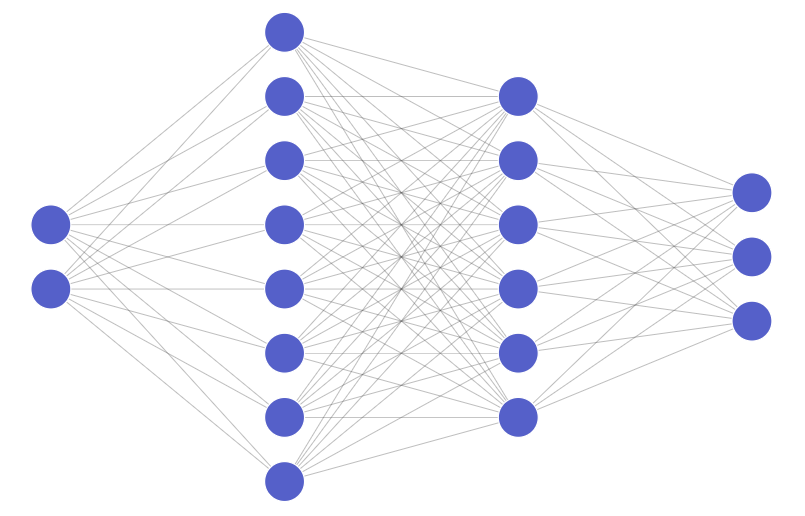

In [14]:
# create Q Network

q_network = nn.Sequential(
    # nn.Linear
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)

)

In [15]:
# create target Q-Network
target_q_network = copy.deepcopy(q_network)
target_q_network = target_q_network.eval()

In [16]:
target_q_network

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

In [17]:
# create epsilon greedy policy

def policy(state, epsilon=0.):

    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1,1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=1, keepdim=True)

In [18]:
policy(next_state)

tensor([[1]])

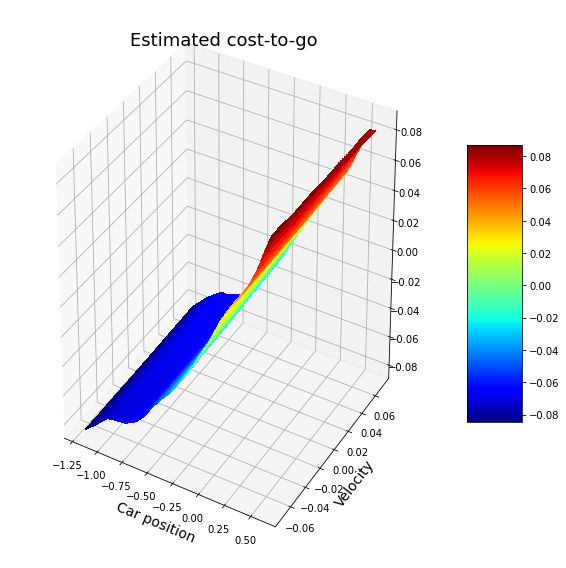

In [19]:
plot_cost_to_go(env, q_network, xlabel="Car position", ylabel="Velocity")

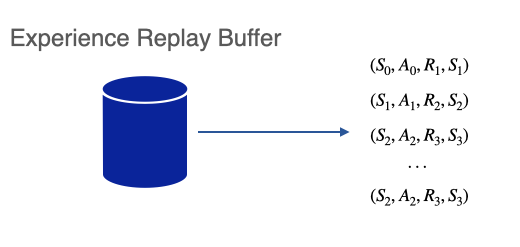

In [20]:
class ReplayMemory():

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # insert
    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    # sample
    def sample(self, batch_size):
        assert self.can_sample(batch_size)
        batch  = random.sample(self.memory, batch_size)

        #[[s,a,r,s'],[s,a,r,s'],[s,a,r,s']] -> [[s,s,s],[a,a,a],[s',s',s']]
        batch = zip(*batch)

        return [torch.cat(items) for items in batch] # N x D tensor


    # can_sampe -> True/False
    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10


    # __len__
    def __len__(self):
        return len(self.memory)

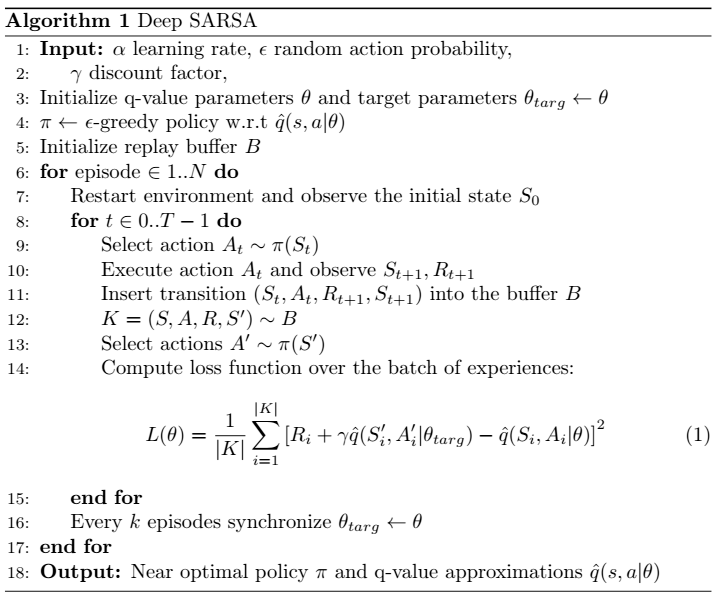

In [21]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.05):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss':[],'Returns':[]}

    for episode in tqdm(range(1, episodes+1)):
        state = env.reset()
        done = False
        ep_return = 0.

        while not done:
            action = policy(state,epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])

            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                
                qsa_b = q_network(state_b).gather(1, action_b)
                next_action_b = policy(next_state_b, epsilon)
                
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                target_b = reward_b + ~done_b * gamma * next_qsa_b

                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                
                loss.backward()
                optim.step()

                stats['MSE Loss'].append(loss.item())
            
            state = next_state
            ep_return += reward.item()

        stats['Returns'].append(ep_return)

        if episode % 10  == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats

In [22]:
stats = deep_sarsa(q_network, policy, 1500, epsilon=0.01)

100%|██████████| 1500/1500 [10:47<00:00,  2.32it/s]


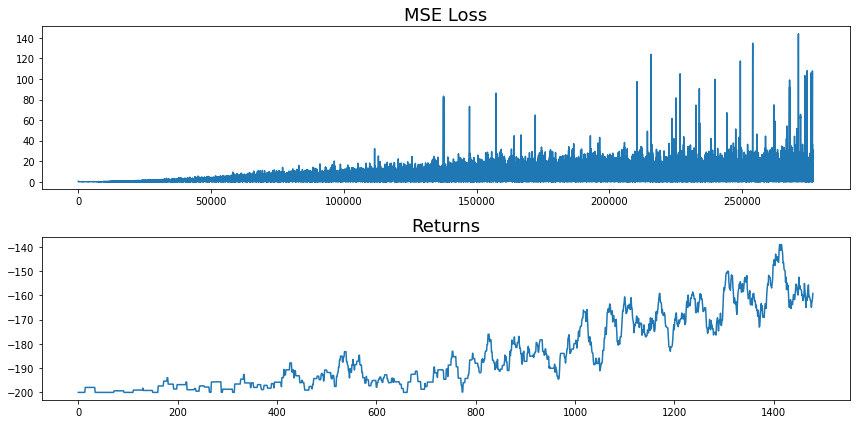

In [23]:
plot_stats(stats)

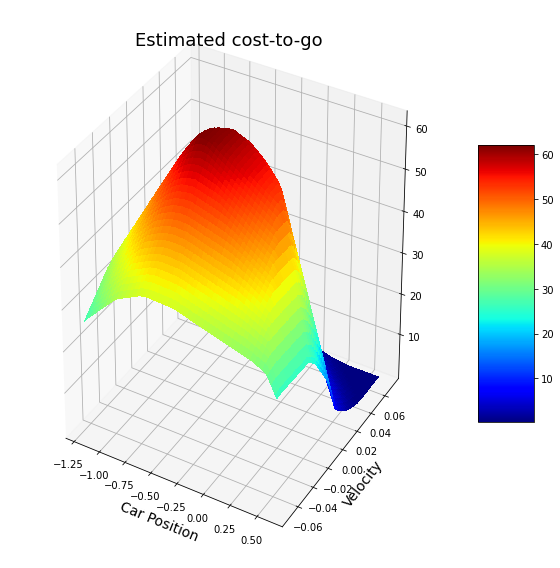

In [24]:
plot_cost_to_go(env, q_network, xlabel = "Car Position", ylabel="Velocity")

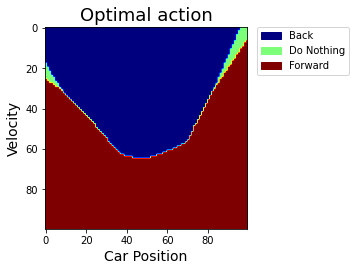

In [25]:
plot_max_q(env, q_network, xlabel = "Car Position", ylabel="Velocity", action_labels=['Back','Do Nothing', 'Forward'])

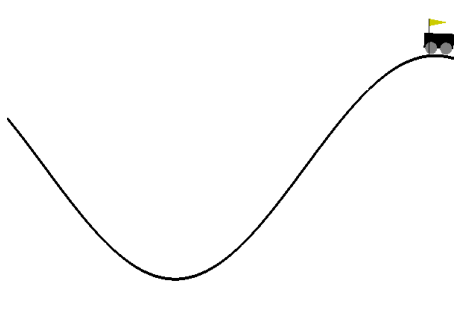

In [26]:
test_agent(env, policy, episodes=2)